In [1]:
import pandas as pd
import plotly_express as px

customer = pd.read_csv('Customer_info.csv')
discount = pd.read_csv('Discount_info.csv')
marketing = pd.read_csv('Marketing_info.csv')
onlinesales = pd.read_csv('Onlinesales_info.csv')
tax = pd.read_csv('Tax_info.csv')

onlinesales.거래날짜 = pd.to_datetime(onlinesales.거래날짜)

In [2]:
onlinesales['소비 금액'] = onlinesales['수량'] * onlinesales['평균금액']

In [3]:
coupon = onlinesales.groupby(['제품카테고리', '쿠폰상태']).size().unstack().reset_index()
coupon['Used_ratio'] = coupon['Used']/(coupon['Clicked'] + coupon['Not Used'] + coupon['Used'])
coupon

쿠폰상태,제품카테고리,Clicked,Not Used,Used,Used_ratio
0,Accessories,125,32,77,0.329060
1,Android,23,10,10,0.232558
2,Apparel,9223,2747,6156,0.339623
3,Backpacks,47,15,27,0.303371
4,Bags,972,285,625,0.332094
5,Bottles,138,48,82,0.305970
6,Drinkware,1752,570,1161,0.333333
7,Fun,83,25,52,0.325000
8,Gift Cards,81,22,56,0.352201
9,Google,51,25,29,0.276190


In [4]:
onlinesales = onlinesales.sort_values(['고객ID', '거래날짜'])
onlinesales['repurchase_interval'] = onlinesales.groupby('고객ID').거래날짜.diff().dt.days

In [5]:
onlinesales['월'] = onlinesales.거래날짜.dt.month
monthly_summary = (
    onlinesales
    .assign(할인여부 = onlinesales['제품카테고리'].isin(set(discount['제품카테고리'])))
    .groupby(['월', '할인여부'])['수량']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={True: 'sales_cnt', False: 'non_sales_cnt'})
)
monthly_summary.columns.name = None
monthly_summary['total_cnt'] = monthly_summary['sales_cnt'] + monthly_summary['non_sales_cnt']
monthly_summary['sales_ratio'] = (monthly_summary['sales_cnt'] / monthly_summary['total_cnt']) * 100

monthly_summary = monthly_summary[['월', 'total_cnt', 'sales_cnt', 'sales_ratio']].reset_index(drop=True)
monthly_summary

,월,total_cnt,sales_cnt,sales_ratio
0,1,20140,19987,99.240318
1,2,16575,16410,99.004525
2,3,20787,20543,98.826189
3,4,25277,24922,98.595561
4,5,18715,18519,98.952712
5,6,21619,21482,99.366298
6,7,22898,22613,98.755350
7,8,27457,27379,99.715919
8,9,19353,19329,99.875988
9,10,17425,17400,99.856528


In [6]:
# coupon.sort_values('Used_ratio', ascending=False)
onlinesales.groupby('쿠폰상태').size()

쿠폰상태
Clicked     26926
Not Used     8094
Used        17904
dtype: int64

객단가 비교

In [7]:
onlinesales['총 주문 금액'] = onlinesales['평균금액'] * onlinesales['수량'] + onlinesales['배송료']
used = onlinesales[onlinesales.쿠폰상태=='Used']
unused = onlinesales[onlinesales.쿠폰상태=='Not Used']

print(used['총 주문 금액'].mean())
print(unused['총 주문 금액'].mean())

# 쿠폰을 써도 매출 증대 효과 없음

97.64872095621091
100.85331233012107


재구매 주기 비교

In [8]:
# customer['used_(used.groupby('고객ID').size().to_frame('cnt').reset_index().cnt/onlinesales.groupby('고객ID').size().to_frame('cnt').reset_index().cnt).values

In [9]:
print(used.repurchase_interval.dropna().mean())
print(unused.repurchase_interval.dropna().mean())

# 리텐션 향상 효과 없음음

1.7742472994713858
1.7340776452676985


In [10]:
# 월별 일괄적인 할인율
discount.groupby('월').할인율.value_counts()

월    할인율
Apr  10     17
Aug  20     17
Dec  30     17
Feb  20     17
Jan  10     17
Jul  10     17
Jun  30     17
Mar  30     17
May  20     17
Nov  20     17
Oct  10     17
Sep  30     17
Name: count, dtype: int64

In [11]:
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

discount['월'] = discount['월'].map(month_map)

In [12]:
monthly_discount = discount.groupby('월').할인율.mean().reset_index()
monthly_sales = onlinesales.groupby('월')['총 주문 금액'].sum().reset_index()


monthly_effect = pd.merge(monthly_discount, monthly_sales, on='월')

monthly_effect['sales_per_discount'] = monthly_effect['할인율']/monthly_effect['총 주문 금액']
monthly_effect

,월,할인율,총 주문 금액,sales_per_discount
0,1,10.0,462866.90,0.000022
1,2,20.0,360036.40,0.000056
2,3,30.0,410408.03,0.000073
3,4,10.0,443100.16,0.000023
4,5,20.0,349159.59,0.000057
5,6,30.0,358594.96,0.000084
6,7,10.0,421362.00,0.000024
7,8,20.0,462309.94,0.000043
8,9,30.0,401553.82,0.000075
9,10,10.0,455643.16,0.000022


In [13]:
discounted_categories = discount['제품카테고리'].unique()
판매효과 = onlinesales[onlinesales['제품카테고리'].isin(discounted_categories)]
카테고리별_판매량 = 판매효과.groupby('제품카테고리')['수량'].sum().sort_values()

In [14]:
new_category = {
    'Nest-USA':'Electronics',
    'Nest':'Electronics',
    'Office':'Stationery',
    'Drinkware':'Lifestyle',
    'Notebooks & Journals':'Stationery',
    'Nest-Canada':'Electronics',
    'Headgear':'Apparel',
    'Gift Cards':'Fun',
    'Google':'Software',
    'Backpacks':'Bags',
    'Accessories':'Lifestyle',
    'Bottles':'Lifestyle',
    'Waze':'Software',
    'Housewares':'Lifestyle',
    'More Bags':'Bags',
    'Android':'Software'
}

discount['제품카테고리'] = discount['제품카테고리'].replace(new_category)
onlinesales['제품카테고리'] = onlinesales['제품카테고리'].replace(new_category)
category_sales = onlinesales.groupby('제품카테고리')['소비 금액'].sum().to_frame('total_sales').reset_index().sort_values('total_sales', ascending=False)
category_cnt = onlinesales.groupby('제품카테고리').size().to_frame('total_cnt').reset_index().sort_values('total_cnt', ascending=False)
category_df = pd.merge(category_sales, category_cnt, how='left', on='제품카테고리')

In [15]:
import plotly.graph_objects as go


fig = go.Figure()


fig.add_trace(go.Bar(
    x=category_df.제품카테고리,
    y=category_df.total_sales,
    name='총 판매 금액',
    text=category_df.total_sales.round(),
    textposition='outside',
    textfont=dict(color='#636EFA'),
    marker=dict(color='#636EFA'),
    yaxis='y1'
))

fig.add_trace(go.Scatter(
    x=category_df.제품카테고리,
    y=category_df.total_cnt,
    text=category_df.total_cnt,
    mode='lines+markers+text',
    name='총 판매 수량',
    line=dict(color='#EF553B', width=2),
    textposition='top center',
    textfont=dict(color='#EF553B'),
    yaxis='y2'
))

fig.update_layout(
    title=dict(
        text='카테고리별 총 판매 금액 및 수량',
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='제품 카테고리',
        tickangle=45
    ),
    yaxis=dict(
        title='총 판매 금액',
        titlefont=dict(color='#636EFA'),
        tickfont=dict(color='#636EFA')
    ),
    yaxis2=dict(
        title='총 판매 수량',
        titlefont=dict(color='#EF553B'),
        tickfont=dict(color='#EF553B'),
        overlaying='y',
        side='right'
    ),
    legend=dict(
        x=0.5,
        xanchor='center',
        y=1.1,
        orientation='h'
    ),
    bargap=0.3,
    height=500,
    template='plotly_white'
)

fig.show()

In [16]:
category_mean_df = onlinesales.groupby('제품카테고리')[['평균금액', '수량']].mean().reset_index().sort_values('평균금액', ascending=False)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=category_mean_df.제품카테고리,
    y=category_mean_df.평균금액,
    name='평균 판매 금액',
    text=category_mean_df.평균금액.round(),
    textposition='outside',
    textfont=dict(color='#636EFA'),
    marker=dict(color='#636EFA'),
    yaxis='y1'
))

fig.add_trace(go.Scatter(
    x=category_mean_df.제품카테고리,
    y=category_mean_df.수량,
    text=category_mean_df.수량.round(),
    mode='lines+markers+text',
    name='평균 판매 수량',
    line=dict(color='#EF553B', width=2),
    textposition='top center',
    textfont=dict(color='#EF553B'),
    yaxis='y2'
))

fig.update_layout(
    title=dict(
        text='카테고리별 평균 판매 금액 및 수량',
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='제품 카테고리',
        tickangle=45
    ),
    yaxis=dict(
        title='평균 판매 금액',
        titlefont=dict(color='#636EFA'),
        tickfont=dict(color='#636EFA')
    ),
    yaxis2=dict(
        title='평균 판매 수량',
        titlefont=dict(color='#EF553B'),
        tickfont=dict(color='#EF553B'),
        overlaying='y',
        side='right'
    ),
    legend=dict(
        x=0.5,
        xanchor='center',
        y=1.1,
        orientation='h'
    ),
    bargap=0.3,
    height=500,
    template='plotly_white'
)

fig.show()

In [17]:
category_customer = onlinesales.groupby(['고객ID', '제품카테고리']).제품ID.size().reset_index().groupby('제품카테고리').agg({'제품ID':'mean', '고객ID':'nunique'}).reset_index()
category_customer.columns = ['제품카테고리', '고객별 평균 주문 수', '총 구매 고객 수']
category_customer = category_customer.sort_values('고객별 평균 주문 수', ascending=False)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=category_customer.제품카테고리,
    y=category_customer['고객별 평균 주문 수'],
    name='고객별 평균 주문 수',
    text=category_customer['고객별 평균 주문 수'].round(),
    textposition='outside',
    textfont=dict(color='#636EFA'),
    marker=dict(color='#636EFA'),
    yaxis='y1'
))

fig.add_trace(go.Scatter(
    x=category_customer.제품카테고리,
    y=category_customer['총 구매 고객 수'],
    text=category_customer['총 구매 고객 수'].round(),
    mode='lines+markers+text',
    name='총 구매 고객 수량',
    line=dict(color='#EF553B', width=2),
    textposition='top center',
    textfont=dict(color='#EF553B'),
    yaxis='y2'
))

fig.update_layout(
    title=dict(
        text='카테고리별 평균 판매 금액 및 수량',
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='제품 카테고리',
        tickangle=45
    ),
    yaxis=dict(
        title='평균 판매 금액',
        titlefont=dict(color='#636EFA'),
        tickfont=dict(color='#636EFA')
    ),
    yaxis2=dict(
        title='평균 판매 수량',
        titlefont=dict(color='#EF553B'),
        tickfont=dict(color='#EF553B'),
        overlaying='y',
        side='right'
    ),
    legend=dict(
        x=0.5,
        xanchor='center',
        y=1.1,
        orientation='h'
    ),
    bargap=0.3,
    height=500,
    template='plotly_white'
)

fig.show()

In [18]:
# 매출 관점에서 제품 카테고리 분류
# 통합한 제품 카테고리별 특징을 바탕으로 매출 관점에서 3가지로 분류하였습니다.
# 매출을 견인하는 제품

# Electronics
# 총 판매금액이 높지만 총 판매수량이 낮습니다.
# 단가가 매우 높고, 많은 수의 고객이 소량으로 꾸준히 구매하는 제품입니다.
# 매출 안정성을 제공하는 제품

# Apparel, Stationery, Living

# 총 판매금액은 다소 낮지만 총 판매수량이 높습니다.
# 단가가 낮지만, 많은 수의 고객이 대량으로(단, Apparel는 소량으로) 꾸준히 자주 구매하는 제품입니다.
# Bags

# 총 판매금액 및 판매수량이 매우 낮고, 단가가 낮습니다.
# 그러나 다수의 고객이 한번에 많이 꾸준히 구매하는 제품입니다.
# 매출 측면의 영향력이 약한 제품

# Software, Fun
# 총판매금액과 총 판매수량 모두 매우 낮고, 구매고객 수가 적으며 구매 빈도 또한 매우 낮습니다.
# 위의 분석 내용을 바탕으로 3차원 좌표 평면 위에 표현한 카테고리의 위치 분포입니다.

In [19]:
onlinesales = pd.merge(onlinesales, discount, how='left', on=['월', '제품카테고리'])

In [20]:
def get_second(x):
    try:
        return x.iloc[1]
    except IndexError:
        return None # 두 번째 값이 없는 경우 None 반환
    
customer_category = onlinesales.groupby(['고객ID']).agg({'소비 금액':'mean', '수량':'mean', '제품ID':'size'}).reset_index()
customer_category_price1 = onlinesales.groupby(['고객ID','제품카테고리']).agg({'소비 금액':'sum', '수량':'sum'}).reset_index().sort_values('소비 금액',ascending=False).groupby('고객ID')['제품카테고리'].first().reset_index()
customer_category_price2 = onlinesales.groupby(['고객ID','제품카테고리']).agg({'소비 금액':'sum', '수량':'sum'}).reset_index().sort_values('소비 금액',ascending=False).groupby('고객ID')['제품카테고리'].apply(get_second).reset_index()
customer_category_amount1 = onlinesales.groupby(['고객ID','제품카테고리']).agg({'소비 금액':'sum', '수량':'sum'}).reset_index().sort_values('수량',ascending=False).groupby('고객ID')['제품카테고리'].first().reset_index()
customer_category_amount2 = onlinesales.groupby(['고객ID','제품카테고리']).agg({'소비 금액':'sum', '수량':'sum'}).reset_index().sort_values('수량',ascending=False).groupby('고객ID')['제품카테고리'].apply(get_second).reset_index()

customer_category.columns = ['고객ID', '주문당 평균 금액', '주문당 평균 수량','총 주문 수']
customer_category_price1.columns = ['고객ID', '1위 주문 카테고리']
customer_category_price2.columns = ['고객ID', '2위 주문 카테고리']
customer_category_amount1.columns = ['고객ID', '1위 금액 카테고리']
customer_category_amount2.columns = ['고객ID', '2위 금액 카테고리']

customer_df = pd.merge(customer_category, customer_category_price1, on='고객ID')
customer_df = pd.merge(customer_df, customer_category_price2, on='고객ID')
customer_df = pd.merge(customer_df, customer_category_amount1, on='고객ID')
customer_df = pd.merge(customer_df, customer_category_amount2, on='고객ID')
customer_df.head(5)

,고객ID,주문당 평균 금액,주문당 평균 수량,총 주문 수,1위 주문 카테고리,2위 주문 카테고리,1위 금액 카테고리,2위 금액 카테고리
0,USER_0000,15.495000,1.500000,4,Apparel,Stationery,Stationery,Apparel
1,USER_0001,212.633750,4.907895,152,Apparel,Electronics,Apparel,Stationery
2,USER_0002,63.707714,8.814286,70,Lifestyle,Electronics,Lifestyle,Stationery
3,USER_0003,92.238571,1.190476,42,Electronics,Apparel,Apparel,Electronics
4,USER_0004,42.010816,1.448980,98,Electronics,Apparel,Stationery,Lifestyle


In [21]:
# # 쿠폰 사용 횟수
# coupon_used_cnt = onlinesales[onlinesales.쿠폰상태=='Used'].groupby('고객ID').size().to_frame('coupon_used_cnt').reset_index()

# # 쿠폰 사용 비율
# used_cnt = onlinesales[onlinesales.쿠폰상태=='Used'].groupby('고객ID').size().to_frame('coupon_used_cnt').reset_index()
# total_cnt = onlinesales.groupby('고객ID').size().to_frame('cnt').reset_index()

# total_cnt['coupon_used_ratio'] = used_cnt.coupon_used_cnt/total_cnt.cnt
# total_cnt['coupon_used_ratio'] = total_cnt['coupon_used_ratio'].fillna(0)

# # 사용 쿠폰의 평균 할인율
# avg_discount = onlinesales[onlinesales.쿠폰상태=='Used'].groupby('고객ID').할인율.mean().to_frame('discount_avg').reset_index()

# # 마지막 구매 이후 경과 일수수
# recency = (onlinesales['거래날짜'].max() - onlinesales.groupby('고객ID').거래날짜.max()).to_frame('recency_days').reset_index()
# recency['recency_days'] = recency['recency_days'].astype(str).str.extract(r'(\d+)').astype(int)

# # 주문당 평균 구매 금액, 총 소비 금액 customer에 있음

# # 데이터 결합
# customer = pd.merge(customer, coupon_used_cnt, how='left', on='고객ID')
# customer = pd.merge(customer, total_cnt[['고객ID', 'coupon_used_ratio']], how='left', on='고객ID')
# customer = pd.merge(customer, avg_discount, how='left', on='고객ID')
# customer = pd.merge(customer, recency, how='left', on='고객ID')
# customer = pd.merge(customer, customer_df[['고객ID', '주문당 평균 금액', '총 주문 수', '주문당 평균 수량']], how='left', on='고객ID')

In [22]:
import pandas as pd

# 1. 쿠폰 사용 횟수
coupon_used_cnt = onlinesales[onlinesales['쿠폰상태'] == 'Used'] \
    .groupby('고객ID') \
    .size() \
    .to_frame('coupon_used_cnt') \
    .reset_index()

# 2. 쿠폰 사용 비율 계산
used_cnt = onlinesales[onlinesales['쿠폰상태'] == 'Used'] \
    .groupby('고객ID') \
    .size() \
    .to_frame('coupon_used_cnt') \
    .reset_index()

total_cnt = onlinesales.groupby('고객ID') \
    .size() \
    .to_frame('cnt') \
    .reset_index()

# 안전한 방식으로 merge 후 계산
total_cnt = pd.merge(total_cnt, used_cnt, how='left', on='고객ID')
total_cnt['coupon_used_ratio'] = total_cnt['coupon_used_cnt'] / total_cnt['cnt']
total_cnt['coupon_used_ratio'] = total_cnt['coupon_used_ratio'].fillna(0)

# 3. 고객별 사용 쿠폰의 평균 할인율
avg_discount = onlinesales[onlinesales['쿠폰상태'] == 'Used'] \
    .groupby('고객ID')['할인율'] \
    .mean() \
    .to_frame('discount_avg') \
    .reset_index()

# 4. 고객별 마지막 구매 이후 경과 일수
recency = onlinesales.groupby('고객ID')['거래날짜'].max().reset_index()
recency['recency_days'] = (onlinesales['거래날짜'].max() - recency['거래날짜']).dt.days
recency = recency[['고객ID', 'recency_days']]

# 5. 주문당 평균 금액 등 기존 customer_df에서 가져오기
# → customer_df는 이전에 만든 고객 요약 테이블로 가정
# 컬럼: 고객ID, 주문당 평균 금액, 총 주문 수, 주문당 평균 수량 등 포함

# 6. 최종 customer 테이블에 결합
customer = pd.merge(customer, coupon_used_cnt, how='left', on='고객ID')
customer = pd.merge(customer, total_cnt[['고객ID', 'coupon_used_ratio']], how='left', on='고객ID')
customer = pd.merge(customer, avg_discount, how='left', on='고객ID')
customer = pd.merge(customer, recency, how='left', on='고객ID')
customer = pd.merge(customer, customer_df[['고객ID', '주문당 평균 금액', '총 주문 수', '주문당 평균 수량']], how='left', on='고객ID')

# 누락값 처리 (쿠폰 사용 안 한 고객 등)
customer[['coupon_used_cnt', 'coupon_used_ratio', 'discount_avg']] = customer[[
    'coupon_used_cnt', 'coupon_used_ratio', 'discount_avg'
]].fillna(0)

# 결과 확인
customer.head()


,고객ID,성별,고객지역,가입기간,coupon_used_cnt,coupon_used_ratio,discount_avg,recency_days,주문당 평균 금액,총 주문 수,주문당 평균 수량
0,USER_1358,남,Chicago,12,257.0,0.308894,10.000000,339,116.916995,832,3.890625
1,USER_0190,남,California,43,49.0,0.404959,22.244898,13,72.860165,121,3.190083
2,USER_0066,남,Chicago,33,27.0,0.264706,17.407407,151,66.738235,102,5.441176
3,USER_0345,여,California,30,0.0,0.000000,0.000000,364,1.240000,5,1.000000
4,USER_0683,남,California,49,5.0,0.294118,26.000000,123,184.177647,17,2.941176


In [23]:
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. 클러스터링에 사용할 특성 선택 및 전처리
features = ['coupon_used_ratio', '총 주문 수', '주문당 평균 수량', '주문당 평균 금액']
X = customer[features].copy()
X = X.fillna(X.mean())  # 결측값 처리

# 2. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. 실루엣 점수 계산
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# 4. Plotly 시각화
fig = px.line(
    x=list(K),
    y=silhouette_scores,
    markers=True,
    labels={'x': 'Number of Clusters (k)', 'y': 'Silhouette Score'},
    title='K 값에 따른 실루엣 계수'
)
fig.update_layout(xaxis=dict(dtick=1), template='plotly_white')
fig.show()


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

optimal_k = 3
print(f"Best K: {optimal_k}, Silhouette Score: {max(silhouette_scores):.3f}")

# --- 4. 최적 K로 클러스터링 ---
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

from sklearn.decomposition import PCA

pca_3d = PCA(n_components=3)
X_pca3d = pca_3d.fit_transform(X_scaled)

pca_df3d = pd.DataFrame(X_pca3d, columns=['PC1', 'PC2', 'PC3'])
pca_df3d['클러스터'] = cluster_labels

fig_pca3d = px.scatter_3d(
    pca_df3d,
    x='PC1',
    y='PC2',
    z='PC3',
    color=pca_df3d['클러스터'].astype(str),
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig_pca3d.update_layout(template='plotly_white',
                        title=dict(text='PCA 기반 3D 클러스터 시각화 (4D 축소)',
                                   x=0.5)
)
fig_pca3d.show()


Best K: 3, Silhouette Score: 0.657


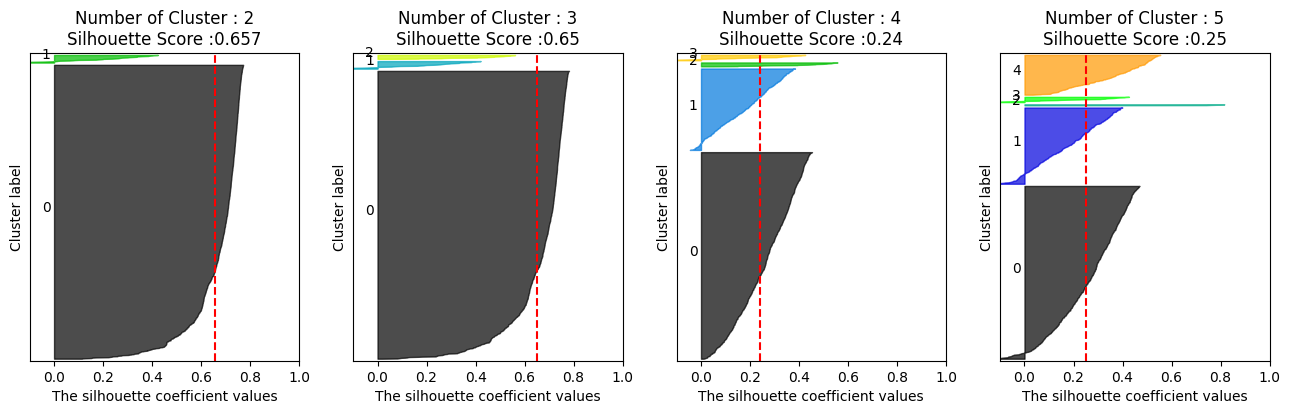

In [25]:
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=300, random_state=42)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, \
                  center_box=(-10.0, 10.0), shuffle=True, random_state=1)  

# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([ 2, 3, 4, 5], X_scaled)


In [26]:
import pandas as pd
from sklearn.cluster import KMeans

def cluster_centroid_summary(X_scaled, original_df, feature_names, n_clusters):
    model = KMeans(n_clusters=n_clusters, random_state=0)
    labels = model.fit_predict(X_scaled)
    centroids = model.cluster_centers_

    df_centroids = pd.DataFrame(centroids, columns=feature_names)
    df_centroids['cluster'] = range(n_clusters)

    # 클러스터별 평균도 같이 비교
    df_original = original_df.copy()
    df_original['cluster'] = labels
    df_mean = df_original.groupby('cluster')[feature_names].mean().reset_index()

    return df_centroids, df_mean

feature_names = ['coupon_used_ratio', 
                  '주문당 평균 금액', '총 주문 수', '주문당 평균 수량']

centroids_scaled, centroids_original = cluster_centroid_summary(
    X_scaled, customer, feature_names, n_clusters=3
)

print("📌 클러스터별 중심 (스케일 기준):")
display(centroids_scaled)

print("📌 클러스터별 평균값 (해석 가능한 원본 값 기준):")
display(centroids_original)



📌 클러스터별 중심 (스케일 기준):


,coupon_used_ratio,주문당 평균 금액,총 주문 수,주문당 평균 수량,cluster
0,-0.011254,-0.062133,-0.180412,-0.272478,0
1,0.069340,-0.317975,1.072274,1.620919,1
2,-0.016843,4.909250,0.010571,0.005616,2


📌 클러스터별 평균값 (해석 가능한 원본 값 기준):


,cluster,coupon_used_ratio,주문당 평균 금액,총 주문 수,주문당 평균 수량
0,0,0.337284,75.946055,87.996753,3.277107
1,1,0.351016,185.001412,53.053140,12.551773
2,2,0.336332,91.963662,767.000000,4.691111


In [27]:
customer['cluster'] = KMeans(n_clusters=3, random_state=0).fit_predict(X_scaled)
customer['segment'] = customer['cluster'].map({
    0:'일반 고객',
    1:'대량 구매 고객',
    2:'충성 고객'
})
cluster_counts = customer['segment'].value_counts(normalize=True).reset_index()
cluster_counts.columns = ['segment', 'ratio']
cluster_counts['ratio'] = cluster_counts['ratio'] * 100

fig = px.pie(cluster_counts, names='segment', values='ratio')

fig.update_layout(title=dict(text='클러스터 비율 분포', 
                             x=0.5
                             ))

fig.update_traces(textinfo='percent+label')
fig.show()


In [28]:
onlinesales = pd.merge(onlinesales, customer[['고객ID', 'segment']], how='left', on='고객ID')

arppu = onlinesales.groupby('월').agg({'소비 금액':'sum', '고객ID':'nunique'}).reset_index()
arppu['ARPPU'] = arppu['소비 금액']/arppu['고객ID']

for i in onlinesales['segment'].unique():
    df = onlinesales[onlinesales.segment==i].groupby('월').agg({'소비 금액':'sum', '고객ID':'nunique'}).reset_index()
    df[i]=df['소비 금액']/df['고객ID']
    arppu=pd.merge(arppu, df[['월', i]], on='월')

arppu = arppu.rename(columns={'월':'month', '고객ID':'고객 수'})

month_segment = onlinesales.groupby(['segment', '월']).agg({'소비 금액':'sum', '고객ID':'size'}).reset_index()
month_sales = pd.pivot_table(month_segment, index='월', columns='segment', values='소비 금액', aggfunc=['sum'])
month_num = pd.pivot_table(month_segment, index='월',  columns='segment',    values='고객ID',  aggfunc=['sum'])

month_sales = month_sales.droplevel(axis=1, level=0).reset_index()
month_num = month_num.droplevel(axis=1, level=0).reset_index()

month_sales

segment,월,대량 구매 고객,일반 고객,충성 고객
0,1,130726.88,821126.02,201477.07
1,2,121604.22,599212.64,145935.38
2,3,165572.90,661791.89,149727.23
3,4,137013.55,597532.72,350529.41
4,5,76512.27,666090.16,108253.04
5,6,122778.03,734507.41,49112.57
6,7,109215.57,696278.80,219382.21
7,8,133199.02,813091.99,153498.96
8,9,145741.86,720899.04,171696.79
9,10,206527.85,850195.28,134587.59


In [29]:
segments = ['대량 구매 고객', '일반 고객', '충성 고객']

fig = go.Figure()
buttons = []

for i, seg in enumerate(segments):
    x = month_sales['월']
    
    # 매출액 (좌측 y축) - Bar, 파란색
    fig.add_trace(go.Bar(
        x=x,
        y=month_sales[seg],
        name='매출액',
        marker_color='#636EFA',
        yaxis='y1',
        visible=(i == 0)
    ))

    # 구매 고객 수 (우측 y축) - Line, 주황색
    fig.add_trace(go.Scatter(
        x=x,
        y=month_num[seg][:len(x)],
        name='구매 고객 수',
        mode='lines+markers',
        line=dict(color='#EF553B'),
        yaxis='y2',
        visible=(i == 0)
    ))

    # 버튼 정의
    visible = [False] * (2 * len(segments))
    visible[i*2] = True
    visible[i*2 + 1] = True

    buttons.append(dict(
        label=seg,
        method='update',
        args=[
            {'visible': visible},
            {'title': f'{seg}의 월별 매출액과 구매 고객 수'}
        ]
    ))

# 레이아웃 설정
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        x=0.1,
        y=1.15,
        showactive=True
    )],
    title=dict(
        text=f'{segments[0]}의 월별 매출액과 구매 고객 수',
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(title='월'),
    yaxis=dict(
        title='매출액',
        titlefont=dict(color='#636EFA'),
        tickfont=dict(color='#636EFA'),
        side='left',
        showgrid=False
    ),
    yaxis2=dict(
        title='구매 고객 수',
        titlefont=dict(color='#EF553B'),
        tickfont=dict(color='#EF553B'),
        overlaying='y',
        side='right',
        showgrid=False
    ),
    legend=dict(
        x=0.5,
        xanchor='center',
        y=1.1,
        orientation='h'
    ),
    bargap=0.3,
    height=500,
    template='plotly_white'
)

fig.show()


In [30]:
customer = pd.merge(customer, customer_df[['고객ID', '1위 주문 카테고리', '1위 금액 카테고리']], how='left', on='고객ID')
customer

,고객ID,성별,고객지역,가입기간,coupon_used_cnt,coupon_used_ratio,discount_avg,recency_days,주문당 평균 금액,총 주문 수,주문당 평균 수량,cluster,segment,1위 주문 카테고리,1위 금액 카테고리
0,USER_1358,남,Chicago,12,257.0,0.308894,10.000000,339,116.916995,832,3.890625,2,충성 고객,Electronics,Lifestyle
1,USER_0190,남,California,43,49.0,0.404959,22.244898,13,72.860165,121,3.190083,0,일반 고객,Electronics,Stationery
2,USER_0066,남,Chicago,33,27.0,0.264706,17.407407,151,66.738235,102,5.441176,0,일반 고객,Electronics,Lifestyle
3,USER_0345,여,California,30,0.0,0.000000,0.000000,364,1.240000,5,1.000000,0,일반 고객,Lifestyle,Lifestyle
4,USER_0683,남,California,49,5.0,0.294118,26.000000,123,184.177647,17,2.941176,1,대량 구매 고객,Electronics,Lifestyle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_0513,여,New York,41,17.0,0.586207,30.000000,0,51.092414,29,2.655172,0,일반 고객,Electronics,Stationery
1464,USER_0167,여,Chicago,48,15.0,0.272727,30.000000,0,163.431636,55,1.745455,1,대량 구매 고객,Electronics,Electronics
1465,USER_0845,남,New Jersey,19,4.0,0.307692,30.000000,0,168.161538,13,2.153846,1,대량 구매 고객,Electronics,Electronics
1466,USER_0504,여,New York,45,5.0,0.217391,30.000000,0,142.523913,23,1.391304,0,일반 고객,Electronics,Electronics


In [31]:
category_counts = customer.groupby(['segment', '1위 금액 카테고리']).size().unstack(fill_value=0)
category_ratio = category_counts.div(category_counts.sum(axis=1), axis=0)
category_ratio = category_ratio.round(2)
category_ratio

1위 금액 카테고리,Apparel,Bags,Electronics,Lifestyle,Software,Stationery
segment,,,,,,
대량 구매 고객,0.09,0.01,0.36,0.30,0.0,0.25
일반 고객,0.15,0.01,0.24,0.38,0.0,0.22
충성 고객,0.03,0.00,0.00,0.83,0.0,0.14


In [32]:
category_counts = customer.groupby(['segment', '1위 주문 카테고리']).size().unstack(fill_value=0)
category_ratio = category_counts.div(category_counts.sum(axis=1), axis=0)
category_ratio = category_ratio.round(2)
category_ratio

1위 주문 카테고리,Apparel,Bags,Electronics,Lifestyle,Software,Stationery
segment,,,,,,
대량 구매 고객,0.09,0.0,0.71,0.13,0.0,0.07
일반 고객,0.09,0.0,0.81,0.07,0.0,0.02
충성 고객,0.00,0.0,1.00,0.00,0.0,0.00


In [33]:
category_segment = customer.groupby(['segment', '1위 금액 카테고리']).size().unstack(fill_value=0).div(category_counts.sum(axis=1), axis=0).fillna(0).reset_index()

category_segment = category_segment.melt(id_vars='segment', var_name='카테고리', value_name='빈도')
category_segment = category_segment.sort_values('빈도')
fig = px.bar(category_segment, 
             y='빈도', x='segment',
             color='카테고리',barmode='group',
             text_auto='.2f')
fig.update_traces(textposition='outside')
fig.update_layout(title=dict(text='세그먼트별 카테고리 지출 비율',
                             x=0.5),
                  xaxis_title='세그먼트',
                  yaxis_title='비율',
                  template='plotly_white')
fig.show()

In [45]:
onlinesales['coupon_used'] = onlinesales['쿠폰상태'].apply(lambda x: 1 if x == 'Used' else 0)

# [2] 세그먼트 × 카테고리별 통계 계산
grouped = onlinesales.groupby(['segment', '제품카테고리']).agg(
    coupon_used_ratio=('coupon_used', 'mean'),
    avg_order_amount=('소비 금액', 'mean'),
    count=('고객ID', 'count')
).reset_index()

# [3] 기대 전환값 계산
grouped['expected_value'] = grouped['coupon_used_ratio'] * grouped['avg_order_amount']

# [4] 사분위 기준 할인율 설정
quartiles = grouped['expected_value'].quantile([0.25, 0.75])

def assign_discount(ev):
    if ev >= quartiles[0.75]:
        return 10  # 상위 25%는 5% 할인으로도 전환 가능
    elif ev >= quartiles[0.25]:
        return 20
    else:
        return 30  # 낮은 기대값은 더 큰 할인 필요

grouped['추천_할인율(%)'] = grouped['expected_value'].apply(assign_discount)

In [50]:
fig = px.histogram(customer, x='coupon_used_cnt')
fig.update_layout(title=dict(text='쿠폰 사용 횟수 분포',
                             x=0.5),
                  xaxis_title='쿠폰 사용 횟수',
                  template='plotly_white')
fig.show()

In [44]:
fig = px.density_heatmap(
    grouped,
    x="제품카테고리",
    y="segment",
    z="expected_value",
    color_continuous_scale="Blues",  # 또는 다른 스케일: 'Blues', 'Plasma', 'Inferno' 등
    text_auto=True  # 셀 안에 값 표시
)

# 레이아웃 조정
fig.update_layout(
    title=dict(text="기대 매출 전환값 (쿠폰 사용률 x 주문당 평균 매출) 히트맵",
               x=0.5),
    xaxis_title="제품 카테고리",
    yaxis_title="고객 세그먼트",
    coloraxis_colorbar=dict(title="쿠폰 사용률 ×  주문당 평균 주문 금액")
)

fig.show()